In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import plotly.graph_objects as go
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteANDDUX/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def split(dataset,train_ratio, test_ratio, val_ratio):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(train_ratio*dataset_size))

  val_test_dataset = dataset.skip(int(train_ratio*dataset_size))
  val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))

  test_dataset = val_test_dataset.skip(int(val_ratio*dataset_size))

  return train_dataset, val_dataset, test_dataset

In [ ]:
train_ratio=0.6
test_ratio=0.2
val_ratio =0.2

train_dataset, val_dataset, test_dataset = split(dataset[0], train_ratio, test_ratio, val_ratio)

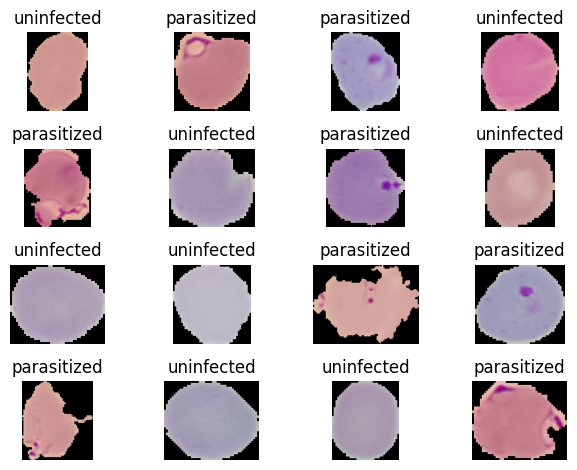

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, 1+i)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')# retirando os valores nos eixos
plt.tight_layout();

# Data Processing

In [ ]:
# função para redimensionalizar a imagem e mudar a escala de cores(ficará entre 0 e 1)
im_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image,(im_size,im_size))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Criando e Treinando o Modelo

In [ ]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(im_size,im_size,3)),

                            Conv2D(filters=6, kernel_size = 3, strides = 1, padding="valid", activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size = 3, strides = 1, padding="valid", activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(100, 'relu'),
                            BatchNormalization(),
                            Dense(10, 'relu'),
                            BatchNormalization(),
                            Dense(1, 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss=BinaryCrossentropy(), metrics = 'accuracy')

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
517/517 [==============================] - 34s 40ms/step - loss: 0.3802 - accuracy: 0.8344 - val_loss: 0.3816 - val_accuracy: 0.8396
Epoch 2/10
517/517 [==============================] - 20s 39ms/step - loss: 0.2333 - accuracy: 0.9140 - val_loss: 0.1996 - val_accuracy: 0.9287
Epoch 3/10
517/517 [==============================] - 19s 37ms/step - loss: 0.1902 - accuracy: 0.9303 - val_loss: 0.2716 - val_accuracy: 0.9109
Epoch 4/10
517/517 [==============================] - 20s 38ms/step - loss: 0.1756 - accuracy: 0.9348 - val_loss: 0.2709 - val_accuracy: 0.9062
Epoch 5/10
517/517 [==============================] - 19s 37ms/step - loss: 0.1350 - accuracy: 0.9508 - val_loss: 0.2239 - val_accuracy: 0.9320
Epoch 6/10
517/517 [==============================] - 20s 39ms/step - loss: 0.0989 - accuracy: 0.9633 - val_loss: 0.2261 - val_accuracy: 0.9329
Epoch 7/10
517/517 [==============================] - 20s 38ms/step - loss: 0.0795 - accuracy: 0.9715 - val_loss: 0.2595 - val_accuracy:

In [ ]:
ind = np.arange(20)


fig = go.Figure()
fig.add_trace(go.Scatter(x=ind, y=history.history['loss'] ,
                    mode='lines',
                    name='Loss Treino'))

fig.add_trace(go.Scatter(x=ind, y=history.history['val_loss'] ,
                    mode='lines+markers',
                    name='Loss Validação'))

fig.update_layout(title_text='Análise Loss')
fig.show()

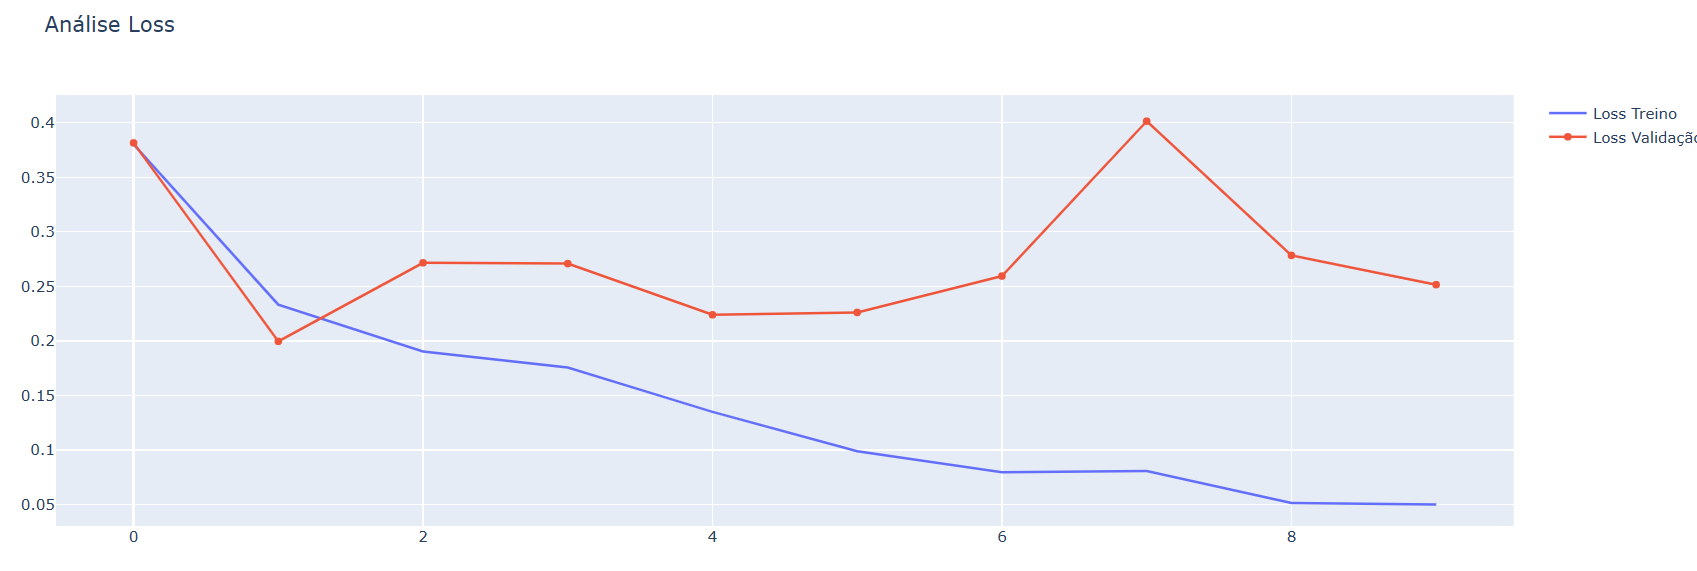

In [ ]:
ind = np.arange(20)


fig = go.Figure()
fig.add_trace(go.Scatter(x=ind, y=history.history['accuracy'] ,
                    mode='lines',
                    name='Acuracia Treino'))

fig.add_trace(go.Scatter(x=ind, y=history.history['val_accuracy'],
                    mode='lines+markers',
                    name='Acuracia Validação'))

fig.update_layout(title_text='Análise Acurácia')
fig.show()

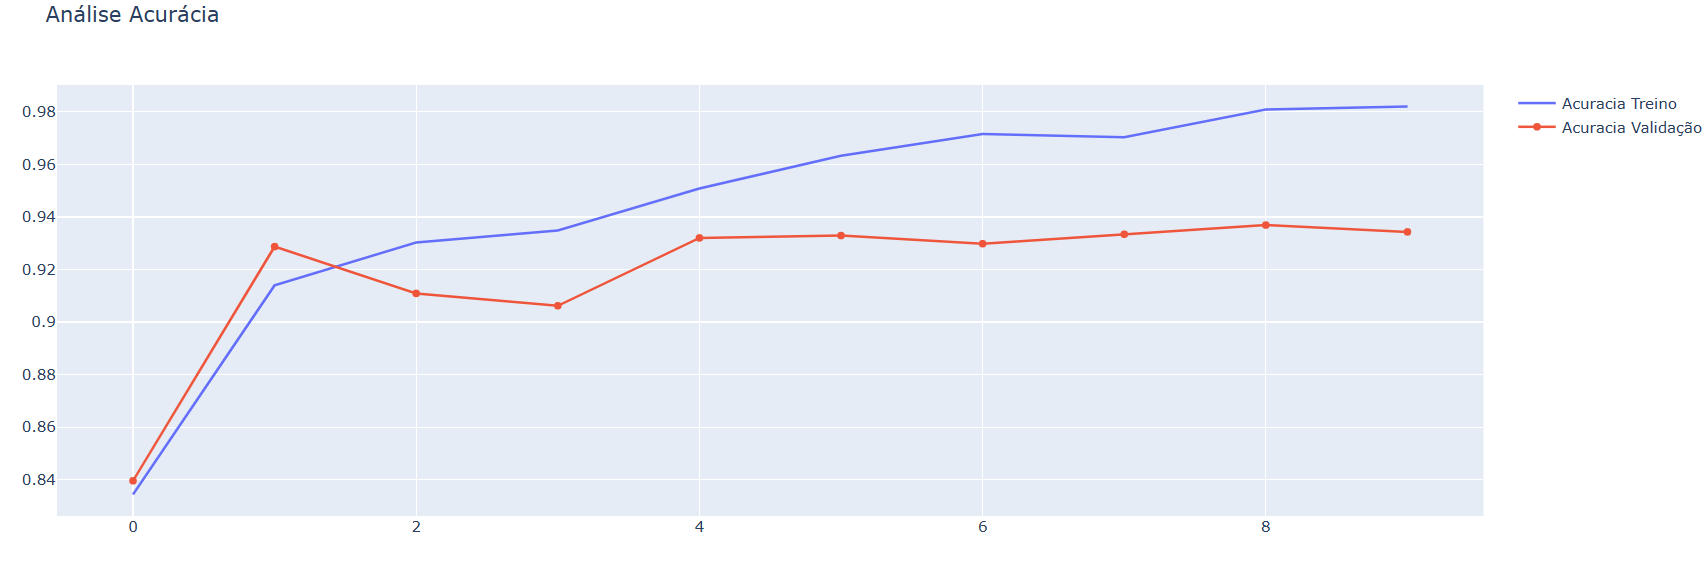

# Avaliação do Modelo

In [ ]:
test_dataset= test_dataset.batch(1)
print(train_dataset), print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


(None, None)

In [ ]:
model.evaluate(test_dataset)[0]

5513/5513 [==============================] - 22s 3ms/step - loss: 0.2517 - accuracy: 0.9356


0.2517120838165283

In [ ]:
def parasita_ou_nao (x):
  if x<0.5:
    return str('P')
  else:
    return str('N')

In [ ]:
parasita_ou_nao(model.predict(test_dataset.take(1)))[0][0]

1/1 [==============================] - 5s 5s/step


'P'

1/1 [==============================] - 0s 22ms/step


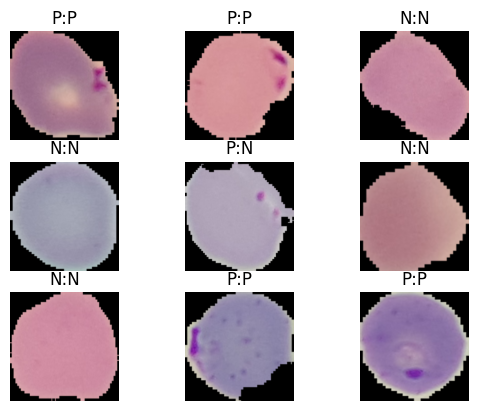

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0]) # especificamos image[0] porque não queremos a dimensão do lote
  plt.title(str(parasita_ou_nao(label.numpy()[0])) + ":" + str(parasita_ou_nao(model.predict(image)[0][0])))
  plt.axis("off");

O valor correto é a esquerda e a direta foi o que o modelo previu.